In [63]:
# Basic environment modules
import numpy as np
import pandas as pd
import psycopg2 as pg # PostgreSQL module
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import font_manager
import matplotlib.font_manager as fm
import seaborn as sns

# Data analysis modules
from CoolProp.CoolProp import PropsSI
from CoolProp.CoolProp import Props
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, PolynomialFeatures, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.integrate import ode
from scipy.interpolate import griddata
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sympy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Database modules
from sqlalchemy import create_engine

# User-defined libraries
from Model import *
from PhysicalProperty import *
from StructuredQuery import *
from Numeric import *
from Authentication import *

# Set the display format to show 6 decimal places
pd.options.display.float_format = '{:.6f}'.format

print("Import modules successfully.")

# Add this line before the loop that iterates over the groups
warnings.filterwarnings('ignore', category=ValueWarning)

# load class instances
sql = StructuredQuery()
pro = PhysicalProperty()
mod = Model()
oau = Authentication()

Import modules successfully.
Construct connection string and update
SQL library is successfully started.
Property_OSV is successfully started.
Models of boiling heat transfer is successfully started.
Authentication is successfully started.


In [64]:
# load data

# Load json file (Security)
json_parse = oau.get_apikey(json_filename='key.json')
json_res = pd.json_normalize(json_parse['sql'])

# Set query from DB
sql = "SELECT * FROM CHF.new_res_chf_tb"

# Connect DB server
#(conn, db_engine) = sql.connect(json_res["host"][1], json_res["dbname"][1], json_res["user"][1], json_res["port"][1], json_res["password"][1], json_res["service"][1]) #postgreSQL
connect = pys.connect(host=json_res["host"][1], user = json_res["user"][1], password = json_res["password"][1], cursorclass=pys.cursors.DictCursor)
cur = connect.cursor()
cur.execute(sql)

result = cur.fetchall()
prop_tb = pd.DataFrame(result)

del result, sql

# Set query from DB
sql = "SELECT * FROM CHF.physicalproperties"
cur.execute(sql)
result = cur.fetchall()
pp_tb = pd.DataFrame(result)
df = pd.DataFrame(result)

cur.close()
del result, sql, connect # delete quiry log

print("Loading database completed. data size: {}".format(len(prop_tb)))
print("Loading database completed. data size: {}".format(len(pp_tb)))

Loading database completed. data size: 20373
Loading database completed. data size: 170


In [65]:
# Show the summary of dataframe
print(len(prop_tb))
prop_tb.head()

20373


,index,idx,tno,runno,geo,flow,refri,hs,p,doi,...,log_id,cal_xt,cal_xe,cal_xosv,converged,alpha,gamma,zxt,qcal,qval
0,0,1,1,1,C,Up,R12,1,10.686785,0.010947,...,0.000000,0.857037,0.857000,-0.202800,100.000000,1.257295,0.339423,5.218338,0.095523,0.296300
1,1,1,2,2,C,Up,R12,1,10.735048,0.010947,...,1.000000,0.852390,0.852400,-0.208000,100.000000,1.259631,0.339090,5.146970,0.099301,0.298600
2,2,1,3,3,C,Up,R12,1,10.735048,0.010947,...,2.000000,0.846873,0.846900,-0.216300,100.000000,1.259631,0.339090,5.063584,0.103575,0.298300
3,3,1,4,4,C,Up,R12,1,10.824679,0.010947,...,3.000000,0.833958,0.834000,-0.230000,100.000000,1.263956,0.338470,4.873967,0.110384,0.289800
4,4,1,5,6,C,Up,R12,1,10.583365,0.010947,...,4.000000,0.786877,0.786900,-0.181500,100.000000,1.252273,0.340135,4.245039,0.105352,0.299300


In [66]:
# Pre-processing

# Filter the dataframe based on the condition Xt > 0
prop_tb = prop_tb[(prop_tb['cal_xt'] > 0) & (prop_tb['refri'] != 'He') & (prop_tb['xi'] > -1) & (prop_tb['q'] < 20)].copy()

for i, row in prop_tb.iterrows():
    prop_tb.loc[i, 'param'] = ((prop_tb.loc[i, 'cpv']*prop_tb.loc[i, 'muv'])/prop_tb.loc[i,'kf'])*(prop_tb.loc[i, 'rhov']/prop_tb.loc[i, 'rhof'])
    if prop_tb.loc[i, 'geo'] == "C":
        prop_tb.loc[i, 'bta'] = (1-prop_tb.loc[i, 'cal_xosv'])/((prop_tb.loc[i, 'qt'])**(1-prop_tb.loc[i, 'dh']))
        prop_tb.loc[i, 'rdmh'] = 1
        prop_tb.loc[i, 'geop'] = 1
    else:
        prop_tb.loc[i, 'bta'] = (1-prop_tb.loc[i, 'cal_xosv'])/(prop_tb.loc[i, 'qt'])**(1-prop_tb.loc[i, 'dio']/prop_tb.loc[i, 'doi'])
        prop_tb.loc[i, 'rdmh'] = (prop_tb.loc[i, 'doi']**2-prop_tb.loc[i, 'dio']**2)/(2*np.log(prop_tb.loc[i, 'doi']/prop_tb.loc[i, 'dio']))
        prop_tb.loc[i, 'geop'] = (prop_tb.loc[i, 'doi']/prop_tb.loc[i, 'dio'])*(prop_tb.loc[i, 'rdmh']-prop_tb.loc[i, 'dio']**2)/(prop_tb.loc[i, 'doi']**2-prop_tb.loc[i, 'rdmh'])
    prop_tb.loc[i, 'kpa'] = 1/prop_tb.loc[i, 'dh']

    if prop_tb.loc[i, 'xi'] < prop_tb.loc[i, 'cal_xosv']:
        prop_tb.loc[i, 'vf_alpha'] = 1/(1+prop_tb.loc[i, 'bta']*np.exp(-prop_tb.loc[i, 'kpa']*prop_tb.loc[i, 'cal_xosv']))
    else:
        prop_tb.loc[i, 'vf_alpha'] = 1/(1+prop_tb.loc[i, 'bta']*np.exp(-prop_tb.loc[i, 'kpa']*prop_tb.loc[i, 'xi']))
    prop_tb.loc[i, 'mass'] = round(PropsSI(prop_tb.loc[i, 'refri'], 'molemass') * 1e3,6)
    prop_tb.loc[i, 'de'], prop_tb.loc[i, 'ph'], prop_tb.loc[i,'af'] = pro.cal_de(prop_tb.loc[i, 'geo'], prop_tb.loc[i, 'hs'], prop_tb.loc[i, 'doi'], prop_tb.loc[i, 'dio'], prop_tb.loc[i, 'dh'], prop_tb.loc[i, 'lh'])
    prop_tb.loc[i,'tcrit'] = round(PropsSI('Tcrit', prop_tb.loc[i, 'refri']), 12)
    
# Drop missing values from the group DataFrame
prop_tb = prop_tb.dropna(subset=['vf_alpha'])

y0 = 0.375
xc = 0.795
aa =  1e-4
wg = 0.5
wl = 0.2
mu = 1000

y00 = 1.25
a0 = -2
xcc = -4
ww = 8.5
a0 = -2
a1 = -0.75
a2 = 1.25

prop_tb['qcosr'] = 8.314*prop_tb['tcrit']*prop_tb['g']/(prop_tb['mass']*1e3)
prop_tb['gcosr'] = 8.314*prop_tb['pcrit']*prop_tb['v']*prop_tb['mass']/(prop_tb['tcrit'])
prop_tb['zxtt'] = (1+prop_tb['vf_alpha']+prop_tb['cal_xt']**2)**3
prop_tb['j_alpha'] = 1.8 - 1.85*(np.abs(prop_tb['rdcp'] - 0.8)**2)
#prop_tb['j_alpha'] = 1.5 + -15.657*prop_tb['rdcp'] + 107.92*prop_tb['rdcp']**2 + -300.6*prop_tb['rdcp']**3 + 362.85*prop_tb['rdcp']**4 + -159.39*prop_tb['rdcp']**5
#prop_tb['j_beta'] = (0.275 + 0.5*np.log(prop_tb['rdcp'])**2 + (2*0.125/3.141592)*(0.0775/(4*(np.log(prop_tb['rdcp'])-0.675)**2 + 0.0775**2)))
prop_tb['j_beta'] = y0 + aa * ( mu * (1/3.141592) *(wl / (25*(np.sqrt(prop_tb['rdcp'])-xc)**2 + wl**2)) + (1 - mu) * (np.sqrt(2*np.log(2)) / (np.sqrt(3.141592) * wg)) * np.exp(-(5*np.log(2)/wg**2)*(np.sqrt(prop_tb['rdcp'])-xc)**2) )
#prop_tb['j_beta'] = 1413.5*prop_tb['rdcp']**6 + -3602.3*prop_tb['rdcp']**5 + 3429.7*prop_tb['rdcp']**4 + -1516.5*prop_tb['rdcp']**3 + 319.25*prop_tb['rdcp']**2 + -29.234*prop_tb['rdcp'] + 1.6076
prop_tb['X'] = -(prop_tb['j_beta']*np.sqrt(prop_tb['gcosr']*prop_tb['cal_xt']*prop_tb['zxt']))
prop_tb['Y'] = np.log(prop_tb['qt']*np.sqrt(prop_tb['dh']**prop_tb['geop']))

prop_tb['Xz'] = (1/np.sqrt(prop_tb['dh']**prop_tb['geop']))*np.exp(-prop_tb['j_beta']*np.sqrt(prop_tb['gcosr']*prop_tb['cal_xt']*prop_tb['zxt']))
prop_tb['Yz'] = prop_tb['qt']

C:\Users\PDL-JHW\AppData\Local\Temp\ipykernel_29964\2407946198.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  prop_tb.loc[i, 'rdmh'] = (prop_tb.loc[i, 'doi']**2-prop_tb.loc[i, 'dio']**2)/(2*np.log(prop_tb.loc[i, 'doi']/prop_tb.loc[i, 'dio']))
C:\Users\PDL-JHW\AppData\Local\Temp\ipykernel_29964\2407946198.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  prop_tb.loc[i, 'geop'] = (prop_tb.loc[i, 'doi']/prop_tb.loc[i, 'dio'])*(prop_tb.loc[i, 'rdmh']-prop_tb.loc[i, 'dio']**2)/(prop_tb.loc[i, 'doi']**2-prop_tb.loc[i, 'rdmh'])
C:\Users\PDL-JHW\AppData\Local\Temp\ipykernel_29964\2407946198.py:15: RuntimeWarning: invalid value encountered in scalar multiply
  prop_tb.loc[i, 'geop'] = (prop_tb.loc[i, 'doi']/prop_tb.loc[i, 'dio'])*(prop_tb.loc[i, 'rdmh']-prop_tb.loc[i, 'dio']**2)/(prop_tb.loc[i, 'doi']**2-prop_tb.loc[i, 'rdmh'])


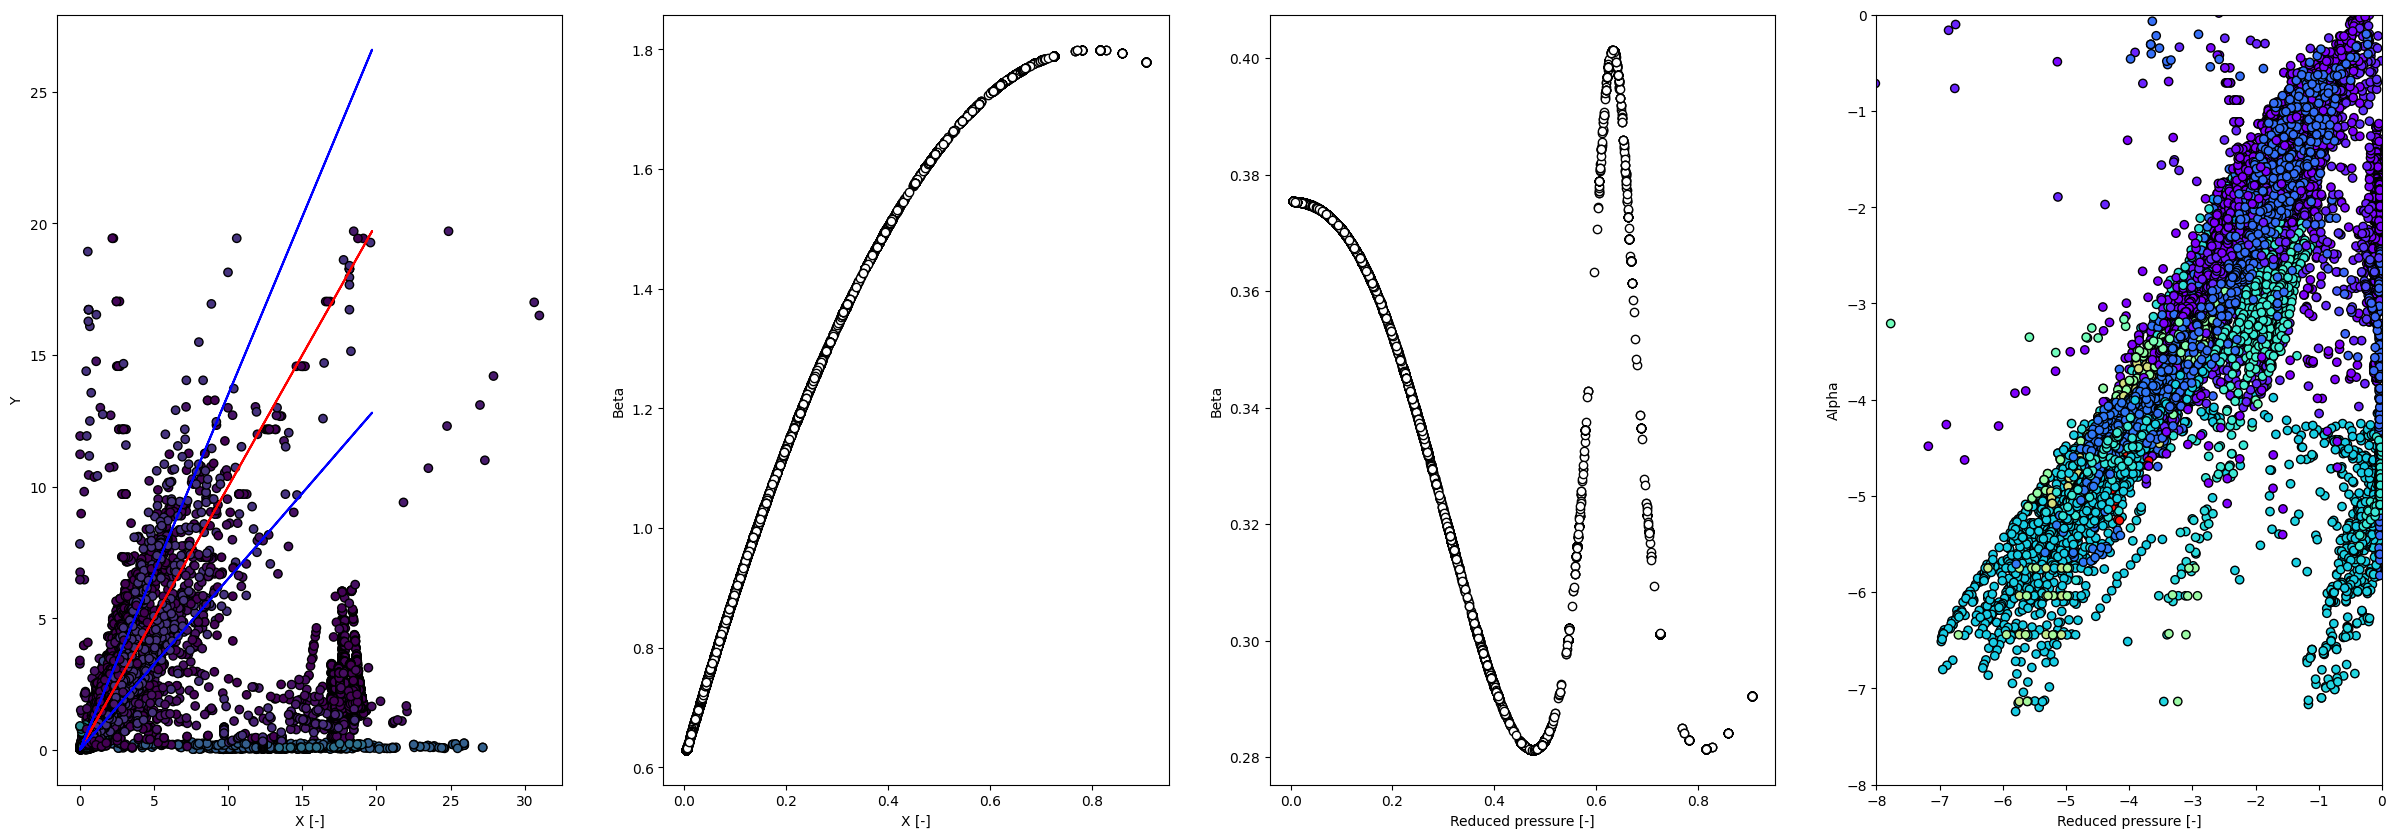

In [67]:
# Create a 1 by 2 subplot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 10))

c = prop_tb['pr']

# Plot intercept vs rdcp in the first subplot
ax1.scatter(prop_tb['Xz'], prop_tb['Yz'], c = c, edgecolors= 'Black', marker='o')
ax1.plot(prop_tb['Yz'], prop_tb['Yz'], color = 'red')
ax1.plot(prop_tb['Yz'], prop_tb['Yz']*0.65, linestyle= '-', color = 'blue')
ax1.plot(prop_tb['Yz'], prop_tb['Yz']*1.35, linestyle= '-', color = 'blue')
ax1.set_xlabel('X [-]')
ax1.set_ylabel('Y')
#ax1.set_xlim(0, 2)
#ax1.set_ylim(0, 2)

# Plot coefficient vs rdcp in the second subplot
ax2.scatter(prop_tb['rdcp'], prop_tb['j_alpha'], color='White', edgecolors= 'Black', marker='o')
#ax2.plot(prop_tb['Y'], prop_tb['Y'], color = 'red')
ax2.set_xlabel('X [-]')
ax2.set_ylabel('Beta')

# Plot coefficient vs rdcp in the second subplot
ax3.scatter((prop_tb['rdcp']), prop_tb['j_beta'], color='White', edgecolors= 'Black', marker='o')
ax3.set_xlabel('Reduced pressure [-]')
ax3.set_ylabel('Beta')

# Plot coefficient vs rdcp in the second subplot
ax4.scatter(prop_tb['X'], prop_tb['Y'], edgecolors= 'Black', c = c, marker='o', cmap='rainbow')
#fig.colorbar(ax4)  # Add colorbar for reference
#ax4.colorbar()  # Add colorbar for reference
ax4.set_xlabel('Reduced pressure [-]')
ax4.set_ylabel('Alpha')
ax4.set_xlim(-8, 0)
ax4.set_ylim(-8, 0)

plt.show()

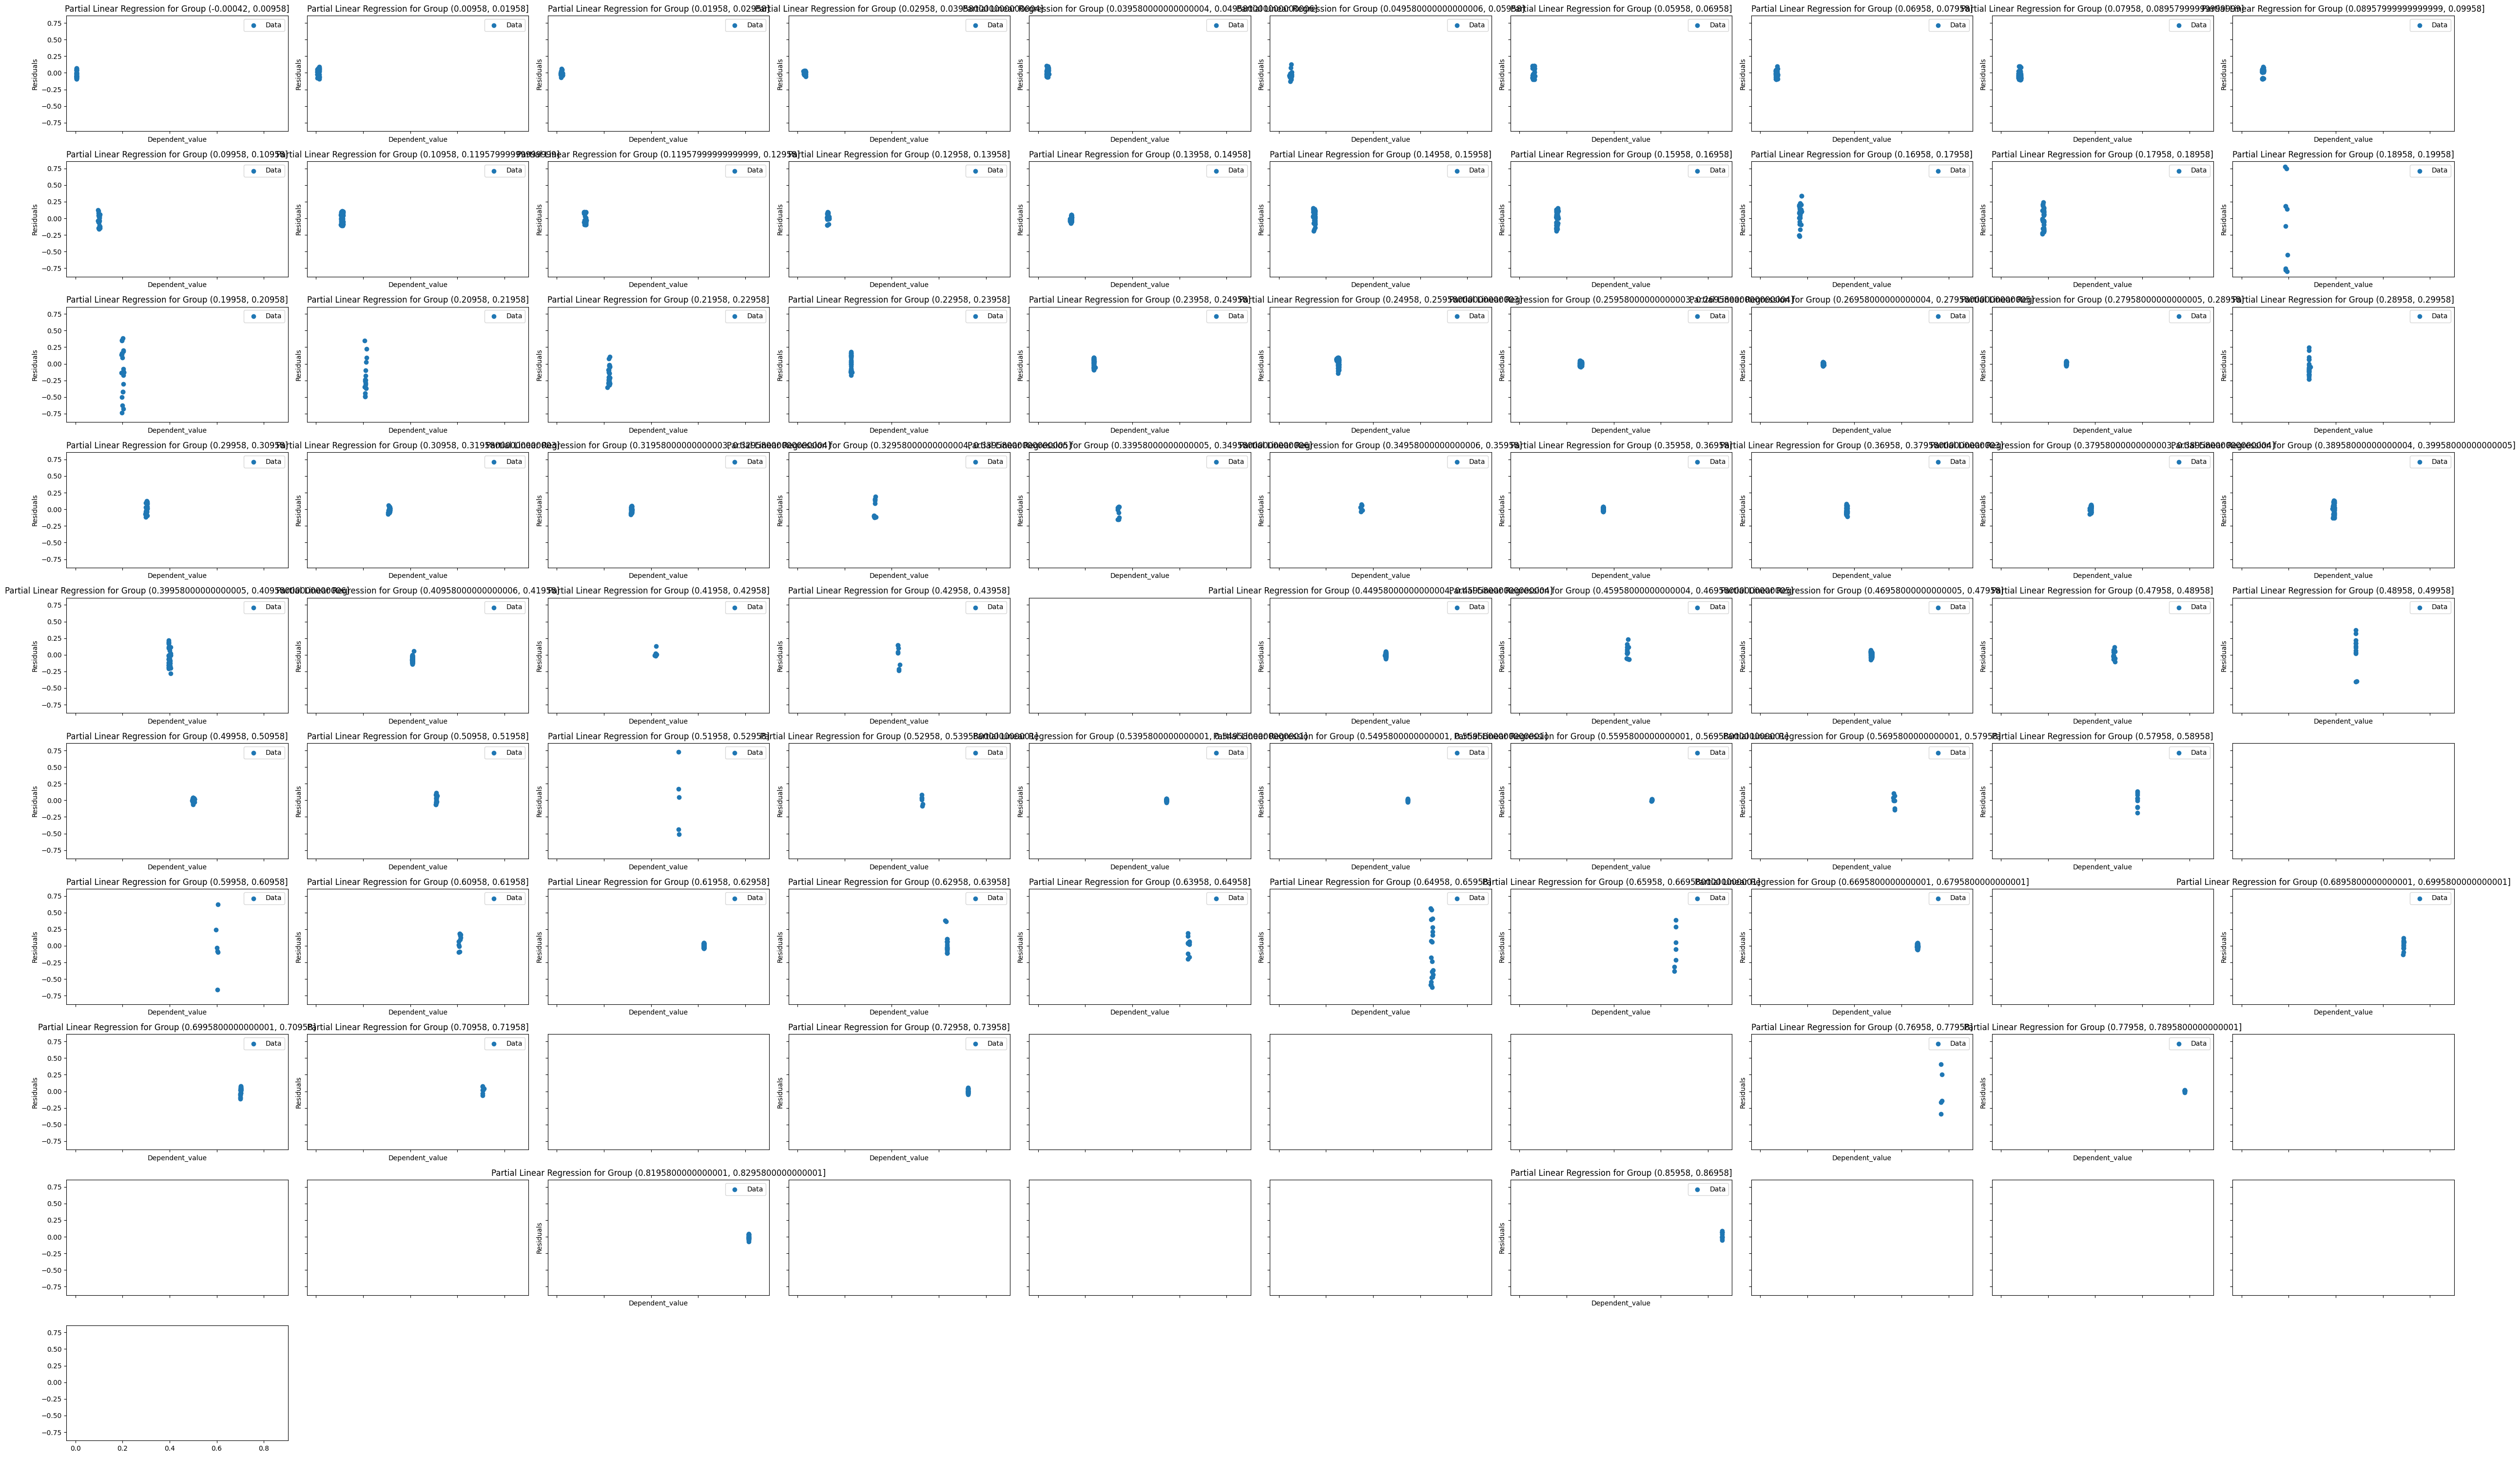

In [68]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans

# Determine the parameter
XX = (prop_tb['rdcp'])

# set bins
bin_size = 0.01  # If you want to adjust the size of the range, change this value
bins = pd.interval_range(start=round(XX.min() - bin_size / 2,5), end=round(XX.max() + bin_size / 2,5), freq=bin_size)
prop_tb['x_range'] = pd.cut(round(XX, 2), bins)

grouped_data = prop_tb.groupby('x_range')

# 각 그룹의 평균 y 값을 계산하고 내림차순으로 정렬
group_mean = grouped_data['rdcp'].mean().sort_values(ascending=False)

# Assign index numbers for labeling
group_labels = {group: f'G{idx + 1}' for idx, group in enumerate(group_mean.index)}

# Extract the range of each group
group_ranges = [(group, group.left, group.right) for group in grouped_data.groups]

# 데이터프레임으로 변환
group_ranges_df = pd.DataFrame(group_ranges, columns=['x_range', 'x_min', 'x_max'])

# group_labels 딕셔너리를 사용하여 각 행에 해당하는 라벨 찾기
prop_tb['group_label'] = prop_tb['x_range'].apply(lambda x: group_labels[x])

# Calculate the number of groups
num_groups = len(grouped_data)

# Calculate the number of columns needed for the subplots
num_columns = math.ceil(num_groups / 10)

# Create subplots for each group in a 10 x n grid
fig, axes = plt.subplots(nrows=10, ncols=num_columns, figsize=(5 * num_columns, 30), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create an empty DataFrame to store the summary results
summary_prop_tb = pd.DataFrame(columns=['Group', 'Intercept'])

# Perform partial linear regression for each group
for ax, (group_name, group_prop_tb) in zip(axes, grouped_data):
    
    # Fit the model without the variable to be partially regressed out
    if len(group_prop_tb) < 5:
        pass
    else:
        partial_model = smf.ols(formula='Y ~ X', data=group_prop_tb).fit()
    
        # Calculate the confidence intervals for each observation
        predictions = partial_model.get_prediction(group_prop_tb)
        conf_int = predictions.conf_int(alpha=0.05)  # 95% confidence level
        
        # Check the shape of conf_int before slicing it
        if conf_int.shape[1] == 1:
            # reshape conf_int to have two columns
            conf_int = np.hstack([conf_int, conf_int])
        
        # Filter the group data to include only observations with a 95% confidence level
        in_confidence_interval = (conf_int[:, 0] <= group_prop_tb['Y']) & (group_prop_tb['Y'] < conf_int[:, 1])
        filtered_group_prop_tb = group_prop_tb[in_confidence_interval]
        
        # Perform the partial regression by regressing the residuals on the remaining independent variable(s)
        residuals = partial_model.resid[in_confidence_interval]
        filtered_group_prop_tb = filtered_group_prop_tb.assign(residuals=residuals)

        # Append the partial regression results for the current group to the summary DataFrame
        val_g = filtered_group_prop_tb['g'].mean()
        val_re = filtered_group_prop_tb['re'].mean()
        val_pr = filtered_group_prop_tb['pr'].mean()
        val_pe = filtered_group_prop_tb['pe'].mean()
        val_rdcp = filtered_group_prop_tb['rdcp'].mean()
        val_dh = filtered_group_prop_tb['dh'].mean()
        val_param = filtered_group_prop_tb['param'].mean()
        val_lh = filtered_group_prop_tb['lh'].mean()
        val_cosr = filtered_group_prop_tb['qcosr'].mean()
        val_gcosr = filtered_group_prop_tb['gcosr'].mean()
        intercept = partial_model.params['Intercept']
        coeff = partial_model.params['X']
        r_squared = partial_model.rsquared
        f_statistic = partial_model.fvalue
        p_value = partial_model.f_pvalue
        num_of_data_points = len(filtered_group_prop_tb)
        summary_prop_tb = pd.concat([summary_prop_tb, pd.DataFrame({'Group': [group_name], 'Intercept': [intercept], 'Coefficient': [coeff], 'R-squared': [r_squared], 'F-statistic': [f_statistic], 'p-value': [p_value], 'No': [num_of_data_points], 'mean_param': [val_param],'mean_dh': [val_dh], 'mean_lh': [val_lh], 'mean_cosr': [val_cosr], 'mean_gcosr': [val_gcosr], 'mean_rdcp': [val_rdcp], 'mean_re': [val_re], 'mean_g': [val_g], 'mean_pr': [val_pr]})], ignore_index=True)

        # Plot the partial linear regression results for each group on the subplot
        ax.scatter(filtered_group_prop_tb['rdcp'], filtered_group_prop_tb['residuals'], label='Data')
        #ax.plot(filtered_group_prop_tb['rdcp'], partial_model.fittedvalues, color='red', label='Fitted Line')
        ax.set_xlabel('Dependent_value')
        ax.set_ylabel('Residuals')
        ax.set_title(f'Partial Linear Regression for Group {group_name}')
        ax.legend()

# Remove any unused subplots
for i in range(num_groups, len(axes)):
    fig.delaxes(axes[i])

# Display the subplots
plt.tight_layout()
plt.show()

In [69]:
# Print the summary DataFrame with partial regression coefficients, intercepts, statistical results, and number of data points for each group
summary_prop_tb

,Group,Intercept,Coefficient,R-squared,F-statistic,p-value,No,mean_param,mean_dh,mean_lh,mean_cosr,mean_gcosr,mean_rdcp,mean_re,mean_g,mean_pr
0,"(-0.00042, 0.00958]",-2.412749,0.058333,0.002147,1.908301,0.167500,41.000000,0.000024,0.004966,0.377644,162.213673,28.946445,0.004622,5029.283971,543.187103,1.750071
1,"(0.00958, 0.01958]",-2.216245,0.344511,0.306668,156.135666,0.000000,30.000000,0.000057,0.006983,0.827533,47.847003,8.676931,0.010153,4275.411533,160.220000,1.447700
2,"(0.01958, 0.02958]",-0.222951,1.091969,0.924629,2527.158086,0.000000,28.000000,0.000133,0.011604,1.839312,835.727978,155.153581,0.021090,225043.719816,2798.510452,1.163875
3,"(0.02958, 0.039580000000000004]",-0.078863,1.124589,0.915228,2224.033811,0.000000,25.000000,0.000231,0.008834,1.508200,154.867690,30.028749,0.031036,27584.966673,528.606607,1.305606
4,"(0.039580000000000004, 0.049580000000000006]",-0.687420,0.876162,0.694141,517.441142,0.000000,53.000000,0.000327,0.008074,1.567250,102.987541,21.548643,0.040106,14926.954670,369.400982,1.337979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,"(0.72958, 0.73958]",0.459271,1.239829,0.922751,1684.259828,0.000000,25.000000,0.139830,0.010005,3.467760,492.864143,144.081672,0.725163,246250.585475,1650.400000,1.361048
70,"(0.76958, 0.77958]",-2.787370,0.586783,0.179466,0.656158,0.477210,5.000000,0.194725,0.007570,2.300000,19.059398,106.971077,0.769315,68790.851840,935.528009,4.537825
71,"(0.77958, 0.7895800000000001]",0.219120,1.046972,0.901139,291.686297,0.000000,9.000000,0.224804,0.001905,0.152400,868.363591,265.021398,0.781090,86443.702860,2907.793742,1.588419
72,"(0.8195800000000001, 0.8295800000000001]",0.689356,1.146379,0.935982,1754.476294,0.000000,24.000000,0.313993,0.010004,3.858000,938.479545,295.272662,0.815809,506109.404062,3142.583333,1.801153


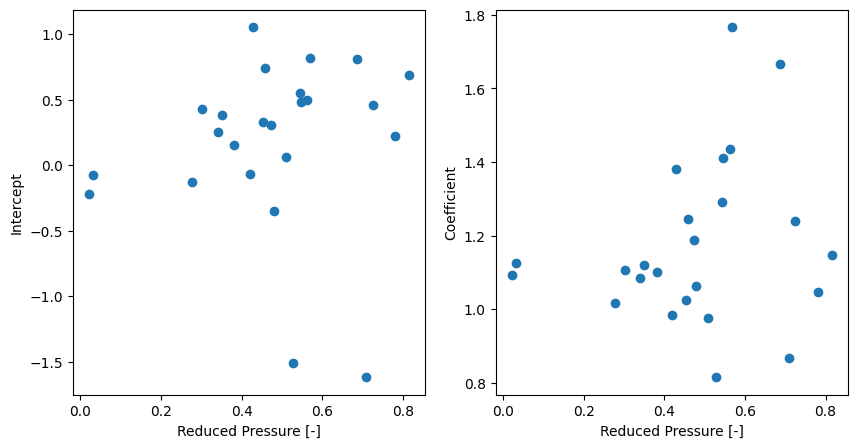

In [70]:
# Extract p value is under 0.05
summary_tb = summary_prop_tb[(summary_prop_tb['p-value'] <= 0.005) & (summary_prop_tb['R-squared'] > 0.90) & (summary_prop_tb['No'] > 5)].copy()

# Extract intercept, coefficient and rdcp from the summary_prop_tb DataFrame
intercepts = summary_tb['Intercept']
coefficients = summary_tb['Coefficient']
val_x = ((summary_tb['mean_rdcp']))

# Create a 1 by 2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot intercept vs rdcp in the first subplot
ax1.scatter(val_x, intercepts)
ax1.set_xlabel('Reduced Pressure [-]')
ax1.set_ylabel('Intercept')

# Plot coefficient vs rdcp in the second subplot
ax2.scatter(val_x, coefficients)
ax2.set_xlabel('Reduced Pressure [-]')
ax2.set_ylabel('Coefficient')

plt.show()
summary_tb['lnIntercept'] = summary_tb.apply(lambda x: np.exp(x['Intercept']), axis=1)
summary_tb.to_csv('summary_prop_tb.csv', index=False)

In [ ]:
filtered_group_prop_tb.rdcp

In [ ]:
# Kmeans Algorithm
# Preparing converged dataset
val_tb = prop_tb[(prop_tb['yn_hval'] == 100) & (prop_tb['idx'] != 31) & (prop_tb['xi'] > -1) & (prop_tb['idx'] != 25) & (abs(prop_tb['qval']) < 0.5)].copy()

# Preparing linear form of CHF correlation
X = val_tb[['p']]

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
# Scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Calculate density of each sample
no_k = 100
wcss = []

for k in range(1, no_k):
    kmeans = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=50)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values as a function of the number of clusters
plt.plot(range(1, no_k), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

from kneed import KneeLocator
# Find the elbow point in the WCSS curve
kneedle = KneeLocator(range(1, no_k), wcss, curve = 'convex', direction='decreasing')
elbow_point = kneedle.elbow
print(elbow_point)

# Run K-means clustering for elbow point
kmeans = KMeans(n_clusters=elbow_point, random_state=0, max_iter=1000, n_init=1).fit(X, sample_weight=1)

# Extract the labels (cluster assignments) and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add the labels and centroids to the original DataFrame
val_tb['cluster'] = labels
val_tb['centroid_distance'] = kmeans.transform(X).min(axis=1)

In [ ]:
# Get the unique groups
groups = val_tb.sort_values('cluster')['cluster'].unique()

# calculate the number of rows and columns
n_groups = len(groups)
n_cols = 3
n_rows = (n_groups + n_cols - 1) // n_cols

# create a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# plot data for each group
for i, group in enumerate(groups):
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    ax.scatter(val_tb.loc[val_tb['cluster'] == group, 'rdcp'], 
                val_tb.loc[val_tb['cluster'] == group, 'q'], 
                label=group)
    ax.set_xlabel('XXX')
    ax.set_ylabel('YYY')
    ax.set_title('Label: '+ str(group))

# adjust the spacing between subplots
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
                    wspace=0.5, hspace=0.5)

# Show plots
plt.show()

In [ ]:
# DBSCAN algorithm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Preparing linear form of CHF correlation
X = val_tb[['rdcp']]

scaler = QuantileTransformer()
X_scaled = scaler.fit_transform(X)

# Run DBSCAN algorithm
dbscan = DBSCAN(eps=0.00001, min_samples = 5)
labels = dbscan.fit_predict(X)

# Plot the results
plt.scatter(X['rdcp'], val_tb['q'], c=labels, cmap ='gist_rainbow')
plt.show()

In [ ]:
# Clustering grouping and calculation for loop

# normalize the dataframe using MinMax Scaler
def cal_mnmx(df, cols):
    # create a MinMaxScaler object
    scaler = MinMaxScaler()

    # fit the scaler to the dataframe
    scaler.fit(df[cols])
    # transform the selected columns of the dataframe using the scaler
    res = pd.DataFrame(scaler.transform(df[cols]), columns=cols)

    return res

from sklearn.metrics import r2_score as r2
# define a function to perform linear regression on a group
def cal_lr(df):
    # create a linear regression object
    model = LinearRegression()
    cluster_value = len(df['cluster'])
    X = df[['X_zxt']].values.reshape(-1,1)
    y = df['Y_qcal'].values.reshape(-1,1)

    # fit the model to the data
    res_model = model.fit(X, y)
    r2_score=r2(y, res_model.predict(X))

    # return the slop and intercept of the regression line
    return pd.Series({'no': cluster_value, 'g_alpha': res_model.intercept_[0], 'g_gamma': res_model.coef_[0][0], 'r2_score': r2_score})

# group the DataFrame by the 'cluster' column
#val_group = val_tb.groupby('cluster').apply(cal_lr)
val_group_tb = val_tb.groupby('cluster').apply(cal_lr).reset_index()
val_group_tb

In [ ]:
# concatenate the two dataframe along rows
result = pd.merge(val_tb, val_group_tb, left_on='cluster', right_on = val_group_tb['cluster'], how='outer').copy()
#result2 = pd.merge(result, tmp_res, on = result.index, how='outer').copy()

# 이 부분은 함수로 데이터프레임에 적용할 수 있도록 수정해야 함.
lr = LinearRegression()


# Set the X and Y data
X = result[['rdcp']]
Y = result['g_alpha']

# Perform polynomial regression
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
lr.fit(X_poly, Y)
r2_train = r2(Y, lr.predict(X_poly))

print('Coefficients: ', lr.coef_)
print('Intercept:', round(lr.intercept_,6))
print('R2: ', round(r2_train*100,2))

# Plot graph
fig = plt.figure()
ax1 = fig.add_subplot(4, 4, 1)
ax2 = fig.add_subplot(4, 4, 2)
ax3 = fig.add_subplot(4, 4, 3)
ax4 = fig.add_subplot(4, 4, 4)

plt.xlabel('Reduced Pressure [-]')
plt.ylabel('Alpha or Gamma')
plt.legend(loc='upper left')
ax1.scatter(result.loc[:, 'rdcp'], result.loc[:, 'g_alpha'], c=result['dh'], cmap ='gist_rainbow')
ax2.scatter(result.loc[:, 'rdcp'], result.loc[:,'g_gamma'], c=result['p'], cmap ='gist_rainbow')
ax3.scatter((result.loc[:, 'X_zxt']), (result.loc[:,'Y_qcal'])/result.loc[:,'g_alpha'], c=result['rdcp'], cmap ='gist_rainbow')
ax4.scatter(result.loc[:,'g_alpha'], result.loc[:,'g_gamma'], c=result['rdcp'], cmap ='gist_rainbow')

#ax1.plot(xs,ys1,'r-',lw=3)
#ax2.plot(xs,ys2,'b-',lw=3)